# TensorFlow

### google 教學
https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb?hl=zh-cn

import packages

In [96]:
import math

from IPython import display
# 在jupyter notebook 上呈現多媒體
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt 通常打這個
# matplotlib 畫圖工具 
%matplotlib inline
#畫圖不用打.slow()
import numpy as np
# 數學計算工具
import pandas as pd
# 資料處理工具
from sklearn import metrics
# python ML-packages
import tensorflow as tf
from tensorflow.python.data import Dataset
# TensorFlow 數據讀取工具

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

import data
加州人口普查數據

In [64]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [66]:
#查看資料
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


先做隨機化處理，避免隨機梯度法效果下降

隨機化處理：http://friskit.me/2014/10/22/shuffle-train-data-in-numpy/

median_house_value 欄位 修改以千為單位，使學習效率增加



In [67]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2943,-117.8,33.8,16.0,3973.0,483.0,1373.0,452.0,9.8,417.0
2383,-117.5,33.7,6.0,454.0,102.0,213.0,43.0,11.0,483.3
12022,-121.4,36.8,52.0,1860.0,400.0,1215.0,367.0,3.0,136.5
9743,-119.6,36.3,32.0,2205.0,523.0,1772.0,479.0,1.4,43.1
16431,-122.6,38.0,38.0,5587.0,996.0,2466.0,1027.0,4.2,336.9
...,...,...,...,...,...,...,...,...,...
13303,-121.9,37.5,10.0,3937.0,1054.0,2032.0,1002.0,3.3,252.2
13090,-121.9,39.7,12.0,14631.0,3298.0,7517.0,3262.0,1.7,153.1
10387,-120.2,36.6,25.0,875.0,214.0,931.0,214.0,1.6,58.3
2377,-117.5,34.1,5.0,2185.0,488.0,1379.0,458.0,3.8,103.0


In [68]:
# 檢查資料
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## 建構模型

將以total_rooms預測median_house_value
使用TensorFlow Estimator API 提供的 LinearRegressor 接口

### 定義特徵列 feature 

取出total_rooms，並定義其為數值(numeric_column)

In [69]:
# Define the input feature: total_rooms.
# 取出total_rooms
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
# 定義為數值
# 轉換成tf的feature_column形式
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

### 定義目標列 label

In [70]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]
#Series形式

### 配置 LinearRegressor

配置LinearRegressor，使用GradientDescentOptimizer（隨機梯度下降法）訓練模型，learning_rate可以控制學習速率

並使用clip_gradients_by_norm（梯度剪裁），確保梯度大小不會變得過大




In [71]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
# 建立一個梯度下降法的機器，學習速率為0.0000001
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
# 使用梯度剪裁，確保梯度不會過大

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
# 建立LR機器，放入feature_columns、optimizer(優化器)

### 定義輸入函數

定義一個輸入函數，先把features轉換成np.array的字典形式

再將特徵向量及標籤使用Dataset轉換成TensorFlow使用的資料型態


batch_size，每次使用的輸入數據數，並按照num_epochs(指定週期數)重複

.repeat(num_epochs) 輸入數據將會無限重複

shuffle=True 數據會進行隨機處理，buffer_size=10000 是指隨機抽樣的大小

最後建立一個迭代器，成為下次LR的輸入資料

In [74]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### 拆解 步驟

In [73]:
# 定義一個輸入函數，先把features轉換成np.array的字典形式
def my_input_fn(features):
    features = {key:np.array(value) for key,value in dict(features).items()}
    print(features)
#結果：
my_input_fn(my_feature) 

{'total_rooms': array([3973.,  454., 1860., ...,  875., 2185., 4599.])}


In [51]:
dict(my_feature).items()

dict_items([('total_rooms', 0       5612.0
1       7650.0
2        720.0
3       1501.0
4       1454.0
         ...  
16995   2217.0
16996   2349.0
16997   2677.0
16998   2672.0
16999   1820.0
Name: total_rooms, Length: 17000, dtype: float64)])

In [53]:
my_input_fn(my_feature) #特徵向量

{'total_rooms': array([5612., 7650.,  720., ..., 2677., 2672., 1820.])}


## 訓練模型
使用linear_regressor.train來訓練模型

用lambda函數建立一個函數，進行100次

In [75]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

## 評估模型

In [83]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): " + str(mean_squared_error))
print ("Root Mean Squared Error (on training data): " + str(root_mean_squared_error))

Mean Squared Error (on training data): 56367.02471498884
Root Mean Squared Error (on training data): 237.41740609102112


比較目標(label)的最大最小值，RMSE過大

In [88]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print ("Min. Median House Value: " + str(min_house_value))
print ("Max. Median House Value: " +  str(max_house_value))
print ("Difference between Min. and Max.: " +  str(min_max_difference))
print ("Root Mean Squared Error: " + str(root_mean_squared_error))

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.00199999999995
Root Mean Squared Error: 237.41740609102112


了解預測狀況與實際label摘要，進而降低誤差

In [89]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [92]:
#隨機抽300個樣本
sample = california_housing_dataframe.sample(n=300)

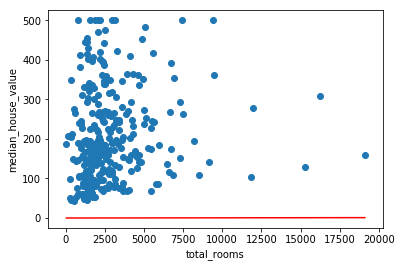

In [97]:
#根據LM模型 畫出散布圖 並劃出回歸線 
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

## 建立一個函數
以便調整參數，計算十次，繪製圖表，以便觀察。

In [105]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print ("Training model...")
  print ("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print ("  period " + str(period)+ " : "+str(root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print ("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print ("Final RMSE (on training data): " + str(root_mean_squared_error))

Training model...
RMSE (on training data):
  period 0 : 225.62632545582488
  period 1 : 214.42079864590627
  period 2 : 204.23879161546603
  period 3 : 195.151951212482
  period 4 : 187.5453923222515
  period 5 : 181.07108651336534
  period 6 : 175.98892601760744
  period 7 : 172.17059554716226
  period 8 : 169.80200679155308
  period 9 : 167.70448393603775
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,114.2,207.3
std,94.2,116.0
min,0.1,15.0
25%,63.2,119.4
50%,91.9,180.4
75%,136.1,265.0
max,1638.9,500.0


Final RMSE (on training data): 167.70448393603775


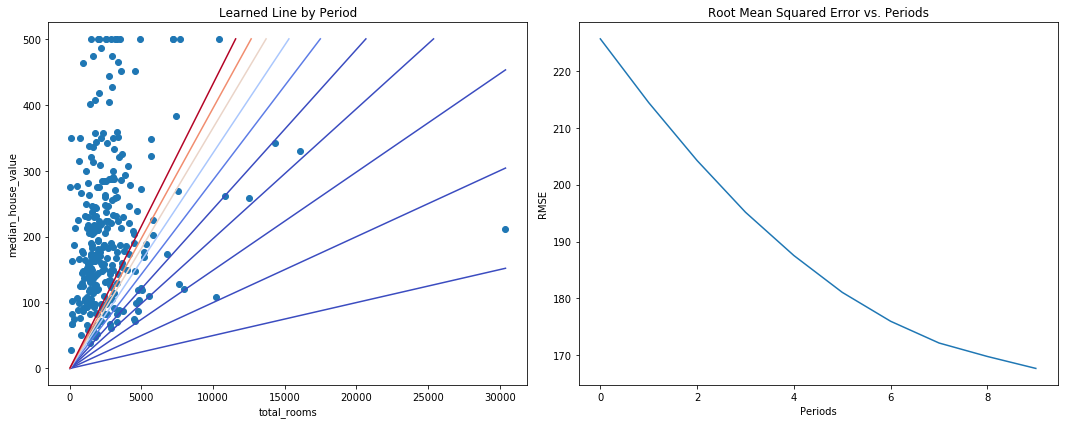

In [112]:
train_model(
    learning_rate=0.00001,
    steps=1000,
    batch_size=1
)

Training model...
RMSE (on training data):
  period 0 : 231.4794212310262
  period 1 : 225.62882717563727
  period 2 : 220.22510057553902
  period 3 : 214.83511117473984
  period 4 : 210.20780864365017
  period 5 : 205.52239372897515
  period 6 : 201.02426846682778
  period 7 : 196.83360007323216
  period 8 : 193.2730107420826
  period 9 : 190.4928803617549
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,67.5,207.3
std,54.2,116.0
min,0.1,15.0
25%,37.3,119.4
50%,55.1,180.4
75%,81.2,265.0
max,1684.2,500.0


Final RMSE (on training data): 190.4928803617549


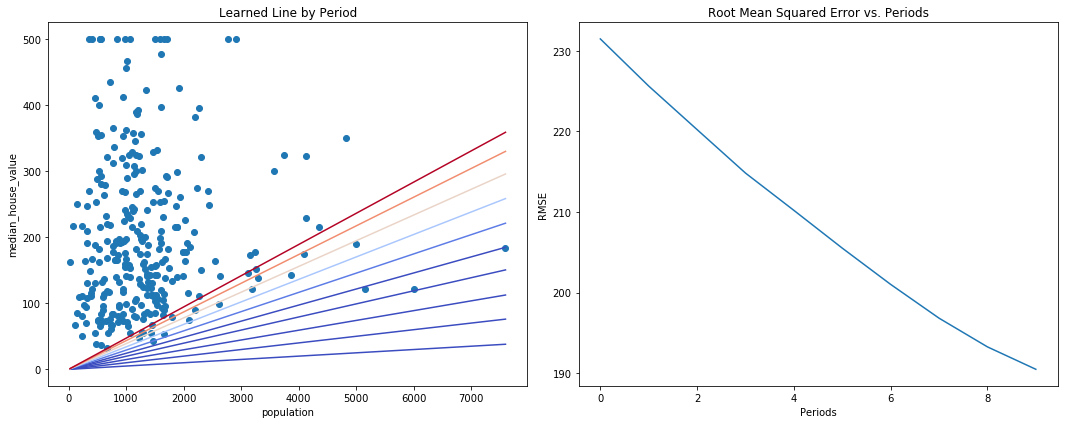

In [113]:
train_model(
    learning_rate=0.00001,
    steps=1000,
    batch_size=1,
    input_feature="population"
)